In [1]:
#Simple 2D Code for visualizing Compressible Hydrodynamics (Flux Conserving)
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
outdir = r"C:\Users\maxri\PyFluid\gifs"
outdir2 = r"C:\Users\nickd\PyFluid\gifs"

100%|██████████| 10000/10000 [00:15<00:00, 654.62it/s]


Flux Method: LLF 
 IC: Sq.Shock 
 B.C.: [0 0 0 0] 
 Nx: 99 
 Steps: 1.000000e+04 
 dt_avg: 7.041e-03 
 Diff Tol: 1.000000e-12 
 Final Time: 70.408


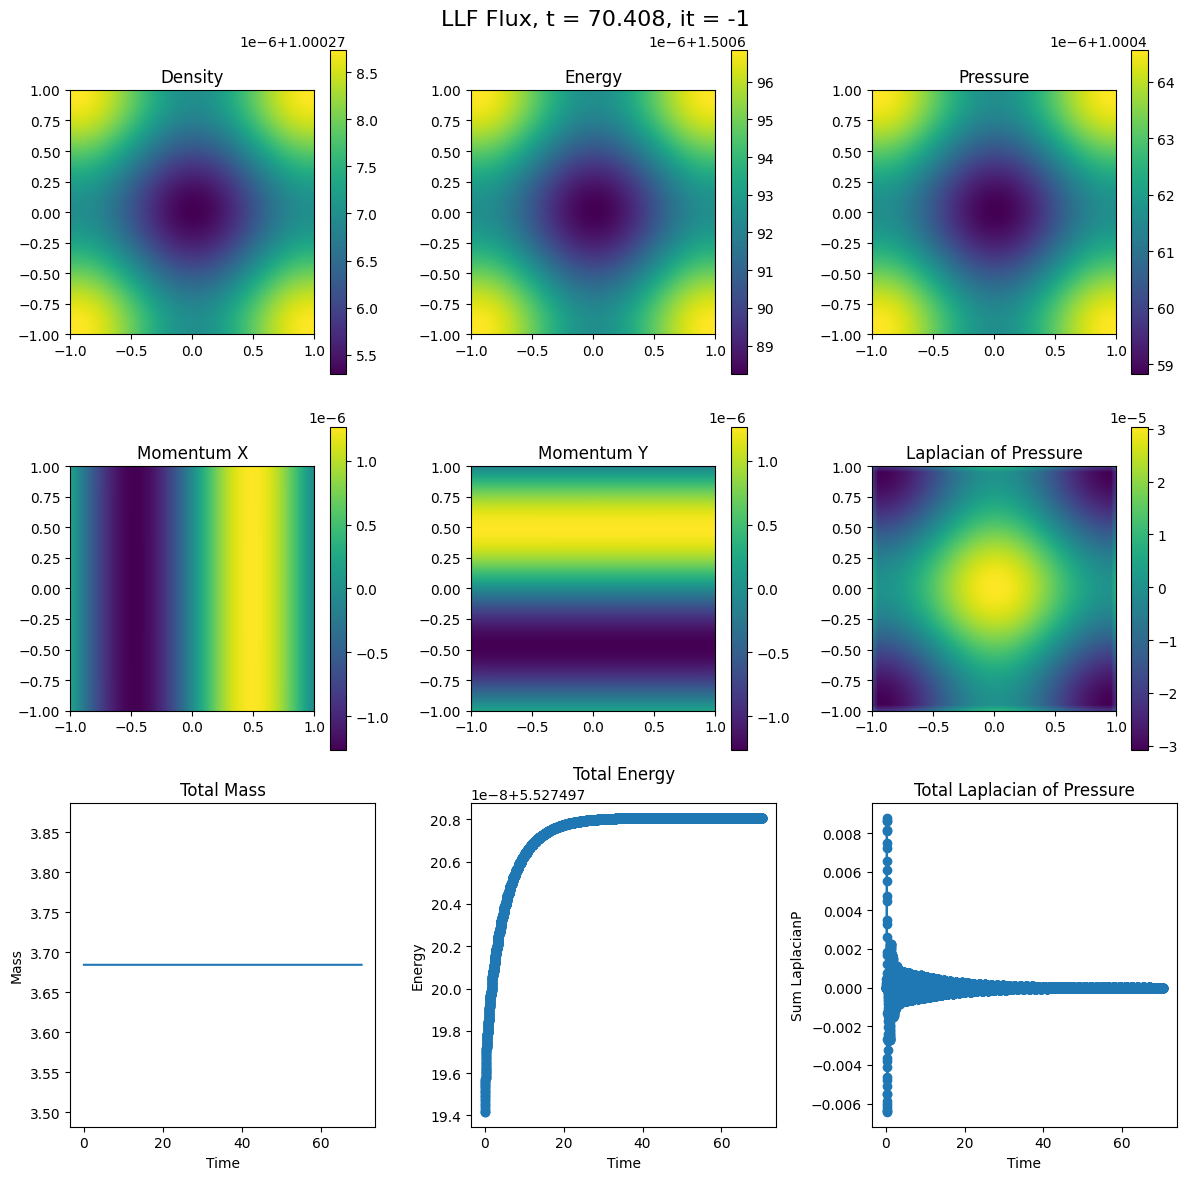

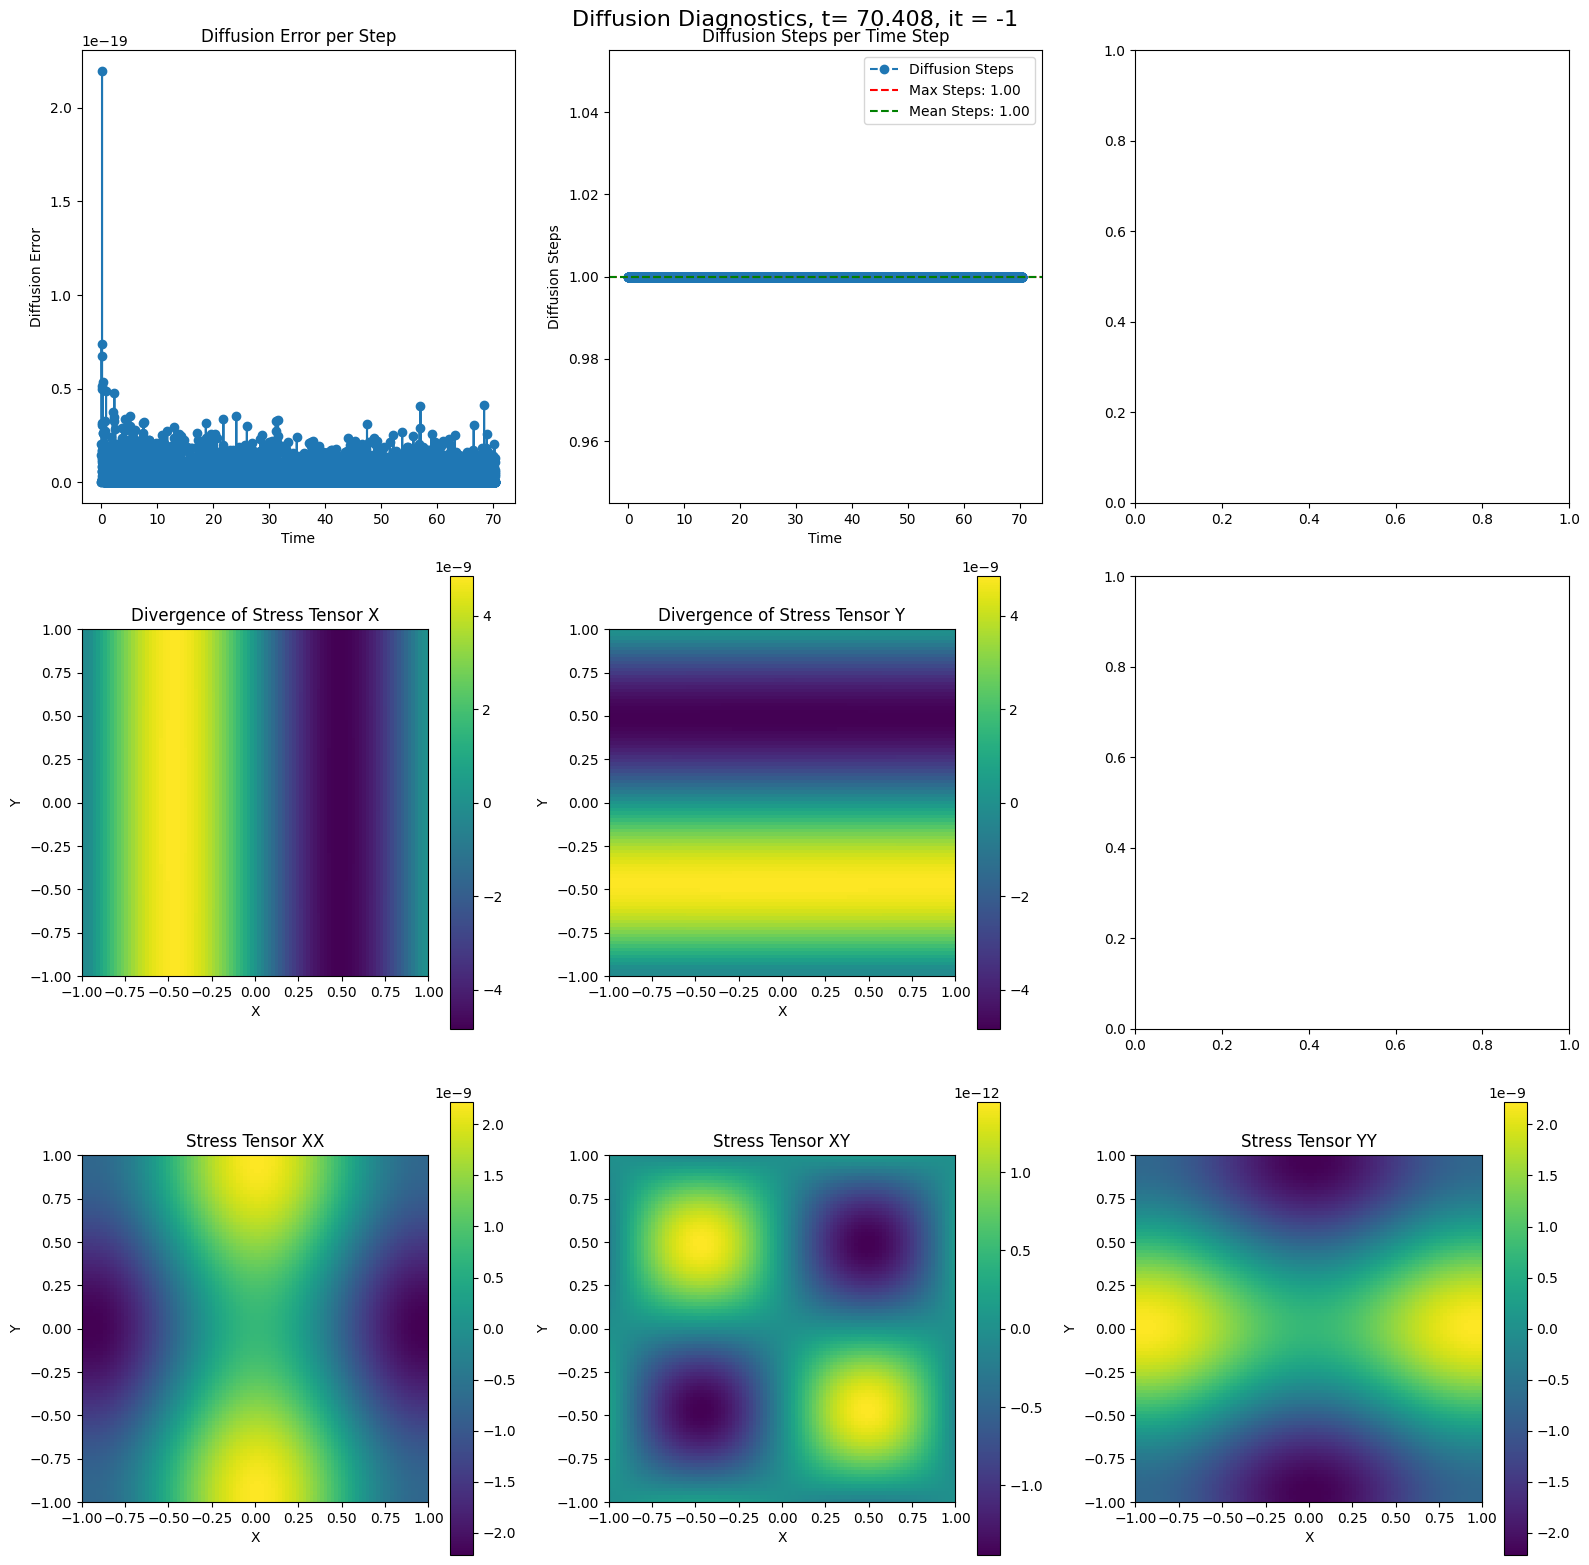

In [9]:
def safe_divide(a,b,out,eps=1e-10):
     # Fill out with zeros first
    out[...] = 0.0
    np.divide(a,np.maximum(b,eps),out=out)
def minmod(a,b,out):
    out[...] = np.where(np.sign(a) == np.sign(b), np.sign(a)*np.min([np.abs(a), np.abs(b)],axis=0), 0.0)
class Fluid2D:
    def __init__(self, x0,x1, nx,ici,bci,Nsteps,flux_meth):
        Nsteps = int(Nsteps)
        #Initialize Grid
        self.x0, self.x1 = x0,x1
        self.L = self.x1 - self.x0
        self.nx = nx
        self.x = np.linspace(x0, x1, nx,endpoint=False);
        self.xg,self.yg = np.meshgrid(self.x, self.x);
        self.dx,self.dy =  self.xg[0,1]-self.xg[0,0],self.yg[1,0]-self.yg[0,0];
        self.rg = np.sqrt(self.xg**2 + self.yg**2);
        #initialize conserved variables and pressure
        self.rho = np.zeros_like(self.xg)   
        self.momentum = np.zeros((2,)+self.xg.shape)
        self.vel = np.zeros((2,)+self.xg.shape)
        self.energy = np.zeros_like(self.xg)
        self.pressure = np.zeros_like(self.xg)
        self.divstress = np.zeros((2,)+self.xg.shape) #xx,xy,yy
        self.stress = np.zeros((3,)+self.xg.shape) #xx,xy,yy

        self.gamma = 5/3; #Hardcoded Gamma
        self.ng = 2; #Hardcoded Number of Ghost Cell

        self.Li = self.x[-self.ng] - self.x[self.ng] #Length of Interior Domain

        #store Initial Condition Index and Boundary Condition Index
        self.bci = bci; 
        self.ici = ici
        
        #Ghost cell vector mask
        self.gmaskv = np.zeros((2,) + self.xg.shape);
        self.gmaskv[1,:self.ng,:] = -1; self.gmaskv[1,-self.ng:,:] = 1;
        self.gmaskv[0,:, :self.ng] = -1; self.gmaskv[0,:, -self.ng:] = 1;
        #ghost cell mask with the corners as 2 and edges as 1
        self.gmaskc = np.linalg.norm(self.gmaskv, axis=0)**2
        #ghost cell mask edges and corners as 1
        self.gmask = self.gmaskc != 0 #Ghost cell Mask
        #interior mask
        self.imask = ~self.gmask
       
        #Number of interior cells
        self.Nint = len(self.xg[self.imask])
        #Number of interior cells in one direction
        self.nxi = nx - 2*self.ng;
        #number of interfaces
        self.nxif = self.nxi + 1;

        #initialize flux method
        self.flux_meth = flux_meth
        if self.flux_meth == 0:
            self.fluxname = "LLF"
        elif self.flux_meth == 1:
            self.fluxname = "HLLE"
        elif self.flux_meth == 2:
            self.fluxname = "HLLC"
        #initialize fluxes
        self.fluxx = np.zeros((4,)+self.xg.shape)
        self.fluxy = np.zeros((4,)+self.xg.shape)
        #initialize solution vector
        self.uvec= np.zeros((4,)+self.xg.shape)
        self.uvect = np.zeros((4,)+self.xg.shape) #temporary solution vector for diffusion iteration
        self.uvecs = np.zeros((Nsteps+1, 4) + self.xg.shape)
        self.pressures = np.zeros((Nsteps+1,) + self.xg.shape); self.gradP = np.zeros((2,) + self.xg.shape)
        self.stresses = np.zeros((Nsteps, 3) + self.xg.shape);
        self.divstresses = np.zeros((Nsteps,2) + self.xg.shape)
        self.ts = np.zeros(Nsteps+1);
        self.dts = np.zeros(Nsteps+1); self.dt = 0;
        #Apply initial conditions
        self.apply_ics()
        #Copy into solution vector and 
        self.copy_forwards()
        #Initialize time diagnostic
        self.t = 0.0
        self.step = 0
        self.cfl = 0.9;
        self.Nsteps = Nsteps
        self.save_state()
        #diffusion constants
        self.difftol = 1e-12;
        self.nu = 0.01*self.cs0*self.dx; #kinematic viscosity
        self.mu = self.nu * self.rhob; #dynamic viscosity
        self.lambdau = -(2/3)*self.mu; #2nd viscosity coeff.
        self.differr = 0.0
        self.differrs = np.zeros(Nsteps)
        self.diffstep = 0
        self.diffsteps = np.zeros(Nsteps)
        self.diffstepmax = 1e4
        #LLF Flux Array Initialization
        self.csg= np.zeros_like(self.xg)
        self.alpx = np.zeros((self.nx, self.nx-1))
        self.alpy = np.zeros((self.nx-1, self.nx))
        self.fluxx_cc = np.zeros((4,self.nxif, self.nxif))
        self.fluxy_cc = np.zeros((4,self.nxif, self.nxif))
        #Diffusion array initialization
        self.dx_vx = np.zeros_like(self.xg); self.dx_vy = np.zeros_like(self.xg)
        self.dy_vx = np.zeros_like(self.xg); self.dy_vy = np.zeros_like(self.xg)
        #HLL Flux Array Initialization
        self.delxuvec = np.zeros((4,self.nxi+3,self.nxi+2))
        self.delyuvec = np.zeros((4,self.nxi+2,self.nxi+3))
        self.dx_uvec = np.zeros((4,self.nxi+3,self.nxi+3))
        self.dy_uvec = np.zeros((4,self.nxi+3,self.nxi+3))
        self.dxrslice= slice(self.ng-1, None if self.ng==2 else -(self.ng-2))
        self.dxlslice = slice(None if self.ng==2 else (self.ng-2), -(self.ng-1))
        self.dyuslice = slice(self.ng-1, None if self.ng==2 else -(self.ng-2))
        self.dydslice = slice(None if self.ng==2 else -(self.ng-2), -(self.ng-1))
        self.uvecL = np.zeros((4,self.nxif, self.nxif))
        self.uvecR = np.zeros((4,self.nxif, self.nxif))
        self.uvecU = np.zeros((4,self.nxif, self.nxif))
        self.uvecD = np.zeros((4,self.nxif, self.nxif))
        self.presL = np.zeros((self.nxif, self.nxif))
        self.presR = np.zeros((self.nxif, self.nxif))
        self.presU = np.zeros((self.nxif, self.nxif))
        self.presD = np.zeros((self.nxif, self.nxif))
        self.velL = np.zeros((2,self.nxif, self.nxif))
        self.velR = np.zeros((2,self.nxif, self.nxif))
        self.velU = np.zeros((2,self.nxif, self.nxif))
        self.velD = np.zeros((2,self.nxif, self.nxif))
        self.csL = np.zeros((self.nxif, self.nxif))
        self.csR = np.zeros((self.nxif, self.nxif))
        self.csU = np.zeros((self.nxif, self.nxif))
        self.csD = np.zeros((self.nxif, self.nxif))
        self.fluxxL = np.zeros((4,self.nxif, self.nxif))
        self.fluxxR = np.zeros((4,self.nxif, self.nxif))
        self.fluxyU = np.zeros((4,self.nxif, self.nxif))
        self.fluxyD = np.zeros((4,self.nxif, self.nxif))
        self.Sstar = np.zeros((2,self.nxif, self.nxif))
        self.fluxxstar = np.zeros((2,4,self.nxif, self.nxif))
        self.fluxystar = np.zeros((2,4,self.nxif, self.nxif))
        self.fluxtemp = np.zeros((4,self.nxif, self.nxif))
        self.fluxxhll = np.zeros((4,self.nxif, self.nxif))
        self.fluxyhll = np.zeros((4,self.nxif, self.nxif))
        if self.flux_meth == 1: #HLLE
           self.Sxstar = np.zeros((2,self.nxif, self.nxif))
           self.Systar = np.zeros((2,self.nxif, self.nxif))
           self.zeroflux = np.zeros((self.nxif, self.nxif))

    def copy_forwards(self):
        self.uvec[0] = self.rho
        self.uvec[1:3] = self.momentum
        self.uvec[3] = self.energy  
    
    def copy_backwards(self):
        self.rho = self.uvec[0]
        self.momentum = self.uvec[1:3]
        self.energy = self.uvec[3]
        safe_divide(self.momentum, self.rho, self.vel)
    
    def closure_ideal(self,uvecf,velf,presf):
        # Ideal gas law closure
        presf[...] = (self.gamma - 1) * (uvecf[3] - 0.5*uvecf[0]*np.linalg.norm(velf, axis=0)**2);

    def compute_LLF_and_update(self):
        # calculate fluxes
        self.flux_init()
        safe_divide(self.pressure, self.rho, self.csg)
        self.csg *= self.gamma; self.csg **= 0.5;
        lam = np.abs(self.vel + self.csg)
        self.alpx=np.maximum(lam[0,:,0:-1],lam[0,:,1:])
        self.alpy=np.maximum(lam[1,0:-1,:],lam[1,1:,:])
        self.dt = self.cfl * self.dx / np.max(self.alpx[self.ng:-self.ng, self.ng-1: -(self.ng)] + self.alpy[self.ng-1:-(self.ng), self.ng: -(self.ng)])
        self.fluxx_cc = 0.5*(self.fluxx[:,:,0:-1] + self.fluxx[:,:,1:]) - 0.5*self.alpx*(self.uvec[:,:,1:] - self.uvec[:,:,0:-1])
        self.fluxy_cc = 0.5*(self.fluxy[:,0:-1,:] + self.fluxy[:,1:,:]) - 0.5*self.alpy*(self.uvec[:,1:,:] - self.uvec[:,0:-1,:])
        delx = self.fluxx_cc[:,self.ng:-(self.ng-1), self.ng: -(self.ng-1)] - self.fluxx_cc[:,self.ng:-(self.ng-1), self.ng-1: -(self.ng)]
        dely = self.fluxy_cc[:,self.ng: -(self.ng-1), self.ng: -(self.ng-1)] - self.fluxy_cc[:,self.ng-1: -(self.ng), self.ng: -(self.ng-1)]
        self.uvec[:,self.ng:-self.ng,self.ng:-self.ng] -= (self.dt / self.dx) * (delx[:,:-1,:] + dely[:,:,:-1])

    def compute_HLL_and_update(self):
       #Compute HLL Fluxes and update solution vector
       self.flux_init()
       safe_divide(self.pressure, self.rho, self.csg)
       self.csg *= self.gamma; self.csg **= 0.5;
       #Compute RHS derivatives at "interfaces", (4,nint + 3)^2
       self.dx_uvec[...] = self.uvec[:,self.dydslice,self.dxrslice] - self.uvec[:,self.dydslice,self.dxlslice]  
       self.dy_uvec[...] = self.uvec[:,self.dyuslice,self.dxlslice] - self.uvec[:,self.dydslice,self.dxlslice] 
       #Use minmod on lhs and rhs derivatives to get limited slopes at gridpoints (4, nint + 2)^2
       minmod(self.dx_uvec[:,:,0:-1], self.dx_uvec[:,:,1:],self.delxuvec)
       minmod(self.dy_uvec[:,0:-1,:], self.dy_uvec[:,1:,:],self.delyuvec)
       #Reconstruct L and R states at interfaces (4, nint + 1)^2
       self.uvecL[...] = self.uvec[:,self.ng-1:-(self.ng),self.ng-1:-(self.ng)] + 0.5*self.delxuvec[:,1:-1,0:-1]   
       self.uvecR[...] = self.uvec[:,self.ng-1:-(self.ng),self.ng:-(self.ng-1)] - 0.5*self.delxuvec[:,1:-1,1:]
       self.uvecU[...] = self.uvec[:,self.ng:-(self.ng-1),self.ng-1:-(self.ng)] + 0.5*self.delyuvec[:,0:-1,1:-1]
       self.uvecD[...] = self.uvec[:,self.ng-1:-(self.ng),self.ng-1:-(self.ng)] - 0.5*self.delyuvec[:,1:,1:-1]
       #Compute velocities for wave speeds at interfaces (2, nint + 1)^2
       safe_divide(self.uvecL[1:3], self.uvecL[0], self.velL); safe_divide(self.uvecR[1:3], self.uvecR[0], self.velR); safe_divide(self.uvecU[1:3], self.uvecU[0], self.velU); safe_divide(self.uvecD[1:3], self.uvecD[0], self.velD);
       #Closure then pressure & cs at interfaces (nint + 1)^2
       self.closure_ideal(self.uvecL, self.velL, self.presL); self.closure_ideal(self.uvecR, self.velR, self.presR); self.closure_ideal(self.uvecU, self.velU, self.presU); self.closure_ideal(self.uvecD, self.velD, self.presD);
       safe_divide(self.gamma*self.presL, self.uvecL[0], self.csL); safe_divide(self.gamma*self.presR, self.uvecR[0], self.csR); safe_divide(self.gamma*self.presU, self.uvecU[0], self.csU); safe_divide(self.gamma*self.presD, self.uvecD[0], self.csD);
       self.csL **= 0.5; self.csR **= 0.5; self.csU **= 0.5; self.csD **= 0.5;
       #SL = np.minimum(self.velL[0] - self.csL, self.velR[0] - self.csR)
       #SR = np.maximum(self.velL[0] + self.csL, self.velR[0] + self.csR)
       #SU = np.maximum(self.velU[1] + self.csU, self.velD[1] + self.csD)
       #SD = np.minimum(self.velU[1] - self.csU, self.velD[1] - self.csD)
       #Analytic fluxes at interfaces (4, nint + 1)^2
       self.calc_fluxes(self.uvecL, self.velL, self.presL,self.fluxxL, self.fluxtemp)
       self.calc_fluxes(self.uvecR, self.velR, self.presR,self.fluxxR, self.fluxtemp)   
       self.calc_fluxes(self.uvecU, self.velU, self.presU,self.fluxtemp, self.fluxyU)
       self.calc_fluxes(self.uvecD, self.velD, self.presD,self.fluxtemp, self.fluxyD)
       if self.flux_meth == 1: #HLLE
            #Roe-averaged states for normal velocity and sound speed at interfaces (nint + 1)^2
            uxroe = (np.sqrt(self.uvecL[0])*self.velL[0] + np.sqrt(self.uvecR[0])*self.velR[0]) / (np.sqrt(self.uvecL[0]) + np.sqrt(self.uvecR[0]))
            uyroe = (np.sqrt(self.uvecD[0])*self.velD[1] + np.sqrt(self.uvecU[0])*self.velU[1]) / (np.sqrt(self.uvecD[0]) + np.sqrt(self.uvecU[0]))
            axroe = (np.sqrt(self.uvecL[0])*self.csL + np.sqrt(self.uvecR[0])*self.csR) / (np.sqrt(self.uvecL[0]) + np.sqrt(self.uvecR[0]))
            ayroe = (np.sqrt(self.uvecD[0])*self.csD + np.sqrt(self.uvecU[0])*self.csU) / (np.sqrt(self.uvecD[0]) + np.sqrt(self.uvecU[0]))
            #Compute HLLE S star speeds (nint + 1)^2
            self.Sxstar[0] = np.min([self.zeroflux,self.velL[0] - self.csL,uxroe - axroe], axis=0)
            self.Sxstar[1] = np.max([self.zeroflux,self.velR[0] + self.csR,uxroe + axroe], axis=0)
            self.Systar[0] = np.min([self.zeroflux,self.velD[1] - self.csD,uyroe - ayroe], axis=0)
            self.Systar[1] = np.max([self.zeroflux,self.velU[1] + self.csU,uyroe + ayroe], axis=0)
            #Compute HLLE fluxes (4, nint + 1)^2
            safe_divide(self.Sxstar[1]*self.fluxxL - self.Sxstar[0]*self.fluxxR + self.Sxstar[0]*self.Sxstar[1]*(self.uvecR - self.uvecL), (self.Sxstar[1] - self.Sxstar[0]), self.fluxxhll)
            safe_divide(self.Systar[1]*self.fluxyD - self.Systar[0]*self.fluxyU + self.Systar[0]*self.Systar[1]*(self.uvecU - self.uvecD), (self.Systar[1] - self.Systar[0]), self.fluxyhll)
            #Compute timestep
            self.dt = self.cfl*self.dx / np.max([np.abs(self.Sxstar), np.abs(self.Systar)])
            #Update solution vector (4, nint)^2
            delx = self.fluxxhll[:,:,1:] - self.fluxxhll[:,:,0:-1]
            dely = self.fluxyhll[:,1:,:] - self.fluxyhll[:,0:-1,:]
            self.uvec[:,self.ng:-self.ng,self.ng:-self.ng] -= (self.dt / self.dx) * (delx[:,:-1,:] + dely[:,:,:-1])
       elif self.flux_meth == 2: #HLLC
          safe_divide( self.presR - self.presL + uvecL[0,:,:] *self.velL[0]*(SL -self.velL[0]) - self.uvecR[0,:,:]*self.velR[0]*(SR -self.velR[0]) , self.uvecL[0,:,:] *(SL -self.velL[0]) - self.uvecR[0,:,:]*(SR -self.velR[0]), self.Sstar[0])
          safe_divide( self.presU - self.presD + uvecD[0,:,:] *self.velD[1]*(SD -self.velD[0]) - self.uvecU[0,:,:]*self.velU[1]*(SU -self.velU[1]) , self.uvecD[0,:,:] *(SD -self.velD[1]) - self.uvecU[0,:,:]*(SU -self.velU[1]), self.Sstar[1])
          self.uxstar[0] = uvecL[0]* (SL - self.velL[0]) / (SL - self.Sstar[0]) * np.stack([np.ones_like(self.Sstar[0]),self.Sstar[0],self.velL[1], uvecL[3] + (self.Sstar[0] - self.velL[0])*self.presL/(uvecL[0]*(SL - self.velL[0]))],axis=0)
          self.uxstar[1] = uvecR[0]* (SR - self.velR[0]) / (SR - self.Sstar[0]) * np.stack([np.ones_like(self.Sstar[0]),self.Sstar[0],self.velR[1], uvecR[3] + (self.Sstar[0] - self.velR[0])*self.presR/(uvecR[0]*(SR - self.velR[0]))],axis=0)
          self.uystar[0] = uvecD[0]* (SD - self.velD[1]) / (SD - self.Sstar[1]) * np.stack([np.ones_like(self.Sstar[0]),self.velD[0],self.Sstar[1], uvecD[3] + (self.Sstar[1] - self.velD[1])*self.presD/(uvecD[0]*(SD - self.velD[1]))],axis=0)
          self.uystar[1] = uvecU[0]* (SU - self.velU[1]) / (SU - self.Sstar[1]) * np.stack([np.ones_like(self.Sstar[0]),self.velU[0],self.Sstar[1], uvecU[3] + (self.Sstar[1] - self.velU[1])*self.presU/(uvecU[0]*(SU - self.velU[1]))],axis=0)
          self.fluxxstar[0] = self.fluxxL + SL * (self.uxstar[0] - uvecL)
          self.fluxxstar[1] = self.fluxxR + SR * (self.uxstar[1] - uvecR)
          self.fluxystar[0] = self.fluxyD + SD * (self.uystar[0] - uvecD)
          self.fluxystar[1] = self.fluxyU + SU * (self.uystar[1] - uvecU)
 
          mask1x = (SL <= 0) ;mask1y = (SD <= 0);
          mask2x = (0 <= SL) & (SL <= self.Sstar[0]) ;mask2y = (0 <= SD) & (SD <= self.Sstar[1]);
          mask3x = (self.Sstar[0] <= 0) & (0 <= SR);mask3y = (self.Sstar[1] <= 0) & (0 <= SU);
          mask4x = (0 <= SR); mask4y = (0 <= SU);
          self.fluxxhll[:,mask1x] = self.fluxxL[:,mask1x]; self.fluxxhll[:,mask4x] = self.fluxxR[:,mask4x];
          self.fluxxhll[:,mask2x] = self.fluxxstar[0][:,mask2x]; self.fluxxhll[:,mask3x] = self.fluxxstar[1][:,mask3x];
          self.fluxyhll[:,mask1y] = self.fluxyD[:,mask1y]; self.fluxyhll[:,mask4y] = self.fluxyU[:,mask4y];
          self.fluxyhll[:,mask2y] = self.fluxystar[0][:,mask2y]; self.fluxyhll[:,mask3y] = self.fluxystar[1][:,mask3y];
          
          delx = self.fluxxhll[:,:,1:] - self.fluxxhll[:,:,0:-1]
          dely = self.fluxyhll[:,1:,:] - self.fluxyhll[:,0:-1,:]
          maxwave = np.max([np.abs(SL),np.abs(SR),np.abs(SU),np.abs(SD)])
          self.dt = self.cfl * self.dx / maxwave
          self.uvec[:,self.ng:-self.ng,self.ng:-self.ng] -= (self.dt / self.dx) * (delx[:,:-1,:] + dely[:,:,:-1])

    def flux_init(self):
        self.copy_backwards()
        self.calc_fluxes(self.uvec, self.vel, self.pressure, self.fluxx, self.fluxy)

    def calc_fluxes(self,uvecf,velf,Pf,fluxx,fluxy):
        fluxx[0], fluxy[0] = uvecf[1:3]; # Continuity
        fluxx[1], fluxy[2] = (velf**2)*uvecf[0] + Pf; # Momentum direct
        fluxx[2] = fluxy[1] = uvecf[1]*velf[1] # also uvecf[2]*velf[0]  , Momentum cross
        fluxx[3],fluxy[3] = velf*(uvecf[3] + Pf); # Energy

    def apply_ics(self):
       self.rhob = 1;self.rhoamp = 1e-3; self.presb = 1.0;
       self.cs0 = np.sqrt(self.gamma * self.presb / self.rhob);
       self.rho[self.imask]+=  self.rhob;
       self.pressure[self.imask] += self.presb;
       if self.ici == 0 or self.ici ==1: #Central Shock
          rsourc = 0.5;
          if self.ici == 0:
            self.icname = "Circ.Shock"
            rmask =  (self.rg <= rsourc) & self.imask
          elif self.ici ==1:
            self.icname = "Sq.Shock"
            rmask = (self.xg >=-rsourc) & (self.xg <= rsourc) & (self.yg >=-rsourc) & (self.yg <= rsourc) &self.imask
          self.rho[rmask] += self.rhoamp;
          self.pressure[rmask] += self.rhoamp * self.cs0**2;
          self.momentum[:,rmask] = 0.0
       elif self.ici ==2: #Wave I.C.
           self.icname = "Wave"
           kx = 2.0*np.pi/(self.Li); ky = 0*2.0*np.pi/(self.Li);
           k = np.sqrt(kx**2 + ky**2);
           if kx !=0:
            xfac =np.sin(kx*self.xg[self.imask]); 
           else:
               xfac = 1
           if ky !=0:
               yfac = np.sin(ky*self.yg[self.imask]);
           else:
               yfac = 1
           self.rho[self.imask] += self.rhoamp * xfac * yfac
           self.momentum[0,self.imask] += self.rhoamp * self.cs0 *(kx/k) * xfac * yfac
           self.momentum[1,self.imask] += self.rhoamp * self.cs0*(ky/k) * xfac * yfac
           self.pressure[self.imask] += (self.cs0**2)*self.rhoamp * xfac * yfac
       elif self.ici ==3: #Stationary Vortex I.C.
           self.icname = "Vortex";
           kx = 2.0*np.pi/(self.Li); ky = 2.0*np.pi/(self.Li);
           k = np.sqrt(kx**2 + ky**2);
           self.momentum[0, self.imask] += self.rhoamp * self.cs0 * np.sin(kx*self.xg[self.imask]) * np.cos(ky*self.yg[self.imask])
           self.momentum[1, self.imask] += -self.rhoamp * self.cs0 * np.cos(kx*self.xg[self.imask]) * np.sin(ky*self.yg[self.imask])
           self.pressure[self.imask] += (self.rho[self.imask]/4)*(self.cs0**2)* (np.cos(2*kx*self.xg[self.imask]) + np.cos(2*ky*self.yg[self.imask]));

       #Initial velocity
       safe_divide(self.momentum, self.rho, self.vel)
       #initial energy
       self.energy = (self.pressure)*(1/(self.gamma-1)) + 0.5*self.rho*np.linalg.norm(self.vel, axis=0)**2;
       #Apply boundary conditions
       self.apply_bcs()
       #Apply closure
       self.closure_ideal(self.uvec, self.vel,self.pressure)

    def apply_bcs(self):
       if np.any(self.bci == 0): #Periodic B.C. Present
          for arr in (self.rho,self.energy,*self.momentum):
             if self.bci[0] == 0: #LHS Periodic
                arr[:,:self.ng] = arr[:, -2*self.ng:-self.ng] 
             if self.bci[1] == 0:  #RHS Periodic
                arr[:,-self.ng:] = arr[:,self.ng:2*self.ng]
             if self.bci[2] == 0:  #BOTTOM Periodic
                arr[:self.ng,:] = arr[-2*self.ng:-self.ng,:]
             if self.bci[3] == 0:  #TOP Periodic
                arr[-self.ng:,:] = arr[self.ng:2*self.ng,:]
       if np.any(self.bci== 1): #Outflow B.C. Present
          for arr in (self.rho,self.energy,*self.momentum):
             if self.bci[0] == 1: #LHS Outflow
                arr[:,:self.ng] = arr[:,self.ng:2*self.ng]
             if self.bci[1] == 1:  #RHS Outflow
                arr[:,-self.ng:] = arr[:,-2*self.ng:-self.ng]
             if self.bci[2] == 1:  #BOTTOM Outflow
                arr[:self.ng,:] = arr[self.ng:2*self.ng,:]
             if self.bci[3] == 1:  #TOP Outflow
                arr[-self.ng:,:] = arr[-2*self.ng:-self.ng,:]
       if np.any(self.bci == 2): #Reflective B.C. Present
            if self.bci[0] == 2: #LHS Reflection
               self.rho[:,:self.ng] = self.rho[:,self.ng:2*self.ng]
               self.energy[:,:self.ng] = self.energy[:,self.ng:2*self.ng]
               self.momentum[:, :, :self.ng] = self.momentum[:, :,self.ng:2*self.ng]
               self.momentum[0,:,:self.ng] *= -1.0   
            if self.bci[1] == 2: #RHS Reflection
               self.rho[:,-self.ng:] = self.rho[:,-2*self.ng:-self.ng]
               self.energy[:,-self.ng:] = self.energy[:,-2*self.ng:-self.ng]
               self.momentum[:,:,-self.ng:] = self.momentum[:,:,-2*self.ng:-self.ng]
               self.momentum[0,:,-self.ng:] *= -1.0
            if self.bci[2] == 2: #BOTTOM Reflection
               self.rho[:self.ng,:] = self.rho[-2*self.ng:-self.ng,:]
               self.energy[:self.ng,:] = self.energy[-2*self.ng:-self.ng,:]
               self.momentum[:, :self.ng,:] = self.momentum[:, -2*self.ng:-self.ng,:]
               self.momentum[1,:self.ng,:] *= -1.0
            if self.bci[3] == 2: #TOP Reflection
               self.rho[-self.ng:,:] = self.rho[-2*self.ng:-self.ng,:]
               self.energy[-self.ng:,:] = self.energy[-2*self.ng:-self.ng,:]
               self.momentum[:, -self.ng:,:] = self.momentum[:, -2*self.ng:-self.ng,:]
               self.momentum[1,-self.ng:,:] *= -1.0
       if np.any((self.bci != 0) & (self.bci != 1) & (self.bci != 2)):
          raise ValueError("Invalid B.C. Key")
       self.copy_forwards() #Update solution vector
       safe_divide(self.momentum[:,self.gmask], self.rho[self.gmask], self.vel[:,self.gmask]) #Update velocity in ghost cells, BC doesn't update velocity

    def calc_stressdivstress(self, uvecf,stresstensorf,divstresstensorf):
        self.dx_vx,self.dx_vy = np.gradient(self.vel,self.dx, axis=2)
        self.dy_vx,self.dy_vy = np.gradient(self.vel,self.dy, axis=1)
        stresstensorf[0] = 2*self.mu*self.dx_vx + self.lambdau*(self.dx_vx + self.dy_vy)
        stresstensorf[1] = self.mu*(self.dy_vx + self.dx_vy)
        stresstensorf[2] = 2*self.mu*self.dy_vy + self.lambdau*(self.dx_vx + self.dy_vy)
        divstresstensorf[0] = np.gradient(stresstensorf[0],self.dx, axis=(1)) + np.gradient(stresstensorf[1],self.dy, axis=(0))
        divstresstensorf[1] = np.gradient(stresstensorf[1],self.dx, axis=(1)) + np.gradient(stresstensorf[2],self.dy, axis=(0))

    def eval_diffus_step(self,uvec1,uvec2,dtf):
       self.calc_stressdivstress(uvec2,self.stress,self.divstress)
       uvec2[1:3]= dtf*self.divstress + uvec1[1:3]   
       self.calc_stressdivstress(uvec2,self.stress,self.divstress)
       self.differr = np.sum(np.abs(uvec2[1:3] - dtf*self.divstress - uvec1[1:3])) / np.sum(np.abs(uvec2[1:3])) #Relative convergence error

    def diff_iteration(self):
       #Diffusion Step
       self.uvect = self.uvec.copy()
       self.diffstep = 1
       self.eval_diffus_step(self.uvec, self.uvect, self.dt)
       while (self.differr > self.difftol) & (self.diffstep < self.diffstepmax):
          self.eval_diffus_step(self.uvec, self.uvect, self.dt)
          self.diffstep += 1
       self.uvec = self.uvect.copy()
       self.copy_backwards()
       sigmadotvx = self.stress[0]*self.vel[0] + self.stress[1]*self.vel[1]
       sigmadotvy = self.stress[1]*self.vel[0] + self.stress[2]*self.vel[1]
       divsigv = np.gradient(sigmadotvx,self.dx, axis=(1)) + np.gradient(sigmadotvy,self.dy, axis=(0))
       dx_vx, dx_vy = np.gradient(self.vel,self.dx, axis=2)
       dy_vx, dy_vy = np.gradient(self.vel,self.dy, axis=1)
       sigcv = dx_vx *self.stress[0] + (dx_vy + dy_vx) * self.stress[1] + dy_vy * self.stress[2]
       self.uvec[3] += self.dt * (divsigv + sigcv)

       self.stresses[self.step] = self.stress
       self.divstresses[self.step] = self.divstress
       self.differrs[self.step] = self.differr
       self.diffsteps[self.step] = self.diffstep
    def save_state(self):
       self.pressures[self.step] = self.pressure
       self.uvecs[self.step] = self.uvec
       self.ts[self.step] = self.t
       self.dts[self.step] = self.dt

    def plot_all(self,it):
      fig, axs = plt.subplots(3,3,figsize=(12, 12))
      fig.suptitle(f"{self.fluxname} Flux, t = {self.ts[it]:.3f}, it = {it}", fontsize=16)
      im0 = axs[0, 0].imshow(self.uvecs[it, 0], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[0, 0].set_title('Density')
      fig.colorbar(im0, ax=axs[0, 0])

      im1 = axs[0, 1].imshow(self.uvecs[it, 3], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[0, 1].set_title('Energy')
      fig.colorbar(im1, ax=axs[0, 1])

      im2 = axs[1, 0].imshow(self.uvecs[it, 1], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[1, 0].set_title('Momentum X')
      fig.colorbar(im2, ax=axs[1, 0])

      im3 = axs[1, 1].imshow(self.uvecs[it, 2], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[1, 1].set_title('Momentum Y')
      fig.colorbar(im3, ax=axs[1, 1])

      im4 = axs[0,2].imshow(self.pressures[it], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[0, 2].set_title('Pressure')
      fig.colorbar(im4, ax=axs[0, 2])

      im5 = axs[1,2].imshow(self.lapPs[it], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[1, 2].set_title('Laplacian of Pressure')
      fig.colorbar(im5, ax=axs[1, 2])

      axs[2,0].plot(self.ts, self.mtots)
      axs[2,0].set_title('Total Mass')
      axs[2,0].set_xlabel('Time')
      axs[2,0].set_ylabel('Mass')

      axs[2,1].plot(self.ts, self.etots, "-o", label='Total Energy')
      axs[2,1].set_title('Total Energy')
      axs[2,1].set_xlabel('Time')
      axs[2,1].set_ylabel('Energy')

      axs[2,2].plot(self.ts, self.laptots, "-o", label='Total LaplacianP')
      axs[2,2].set_title('Total Laplacian of Pressure')
      axs[2,2].set_xlabel('Time')
      axs[2,2].set_ylabel('Sum LaplacianP')

      plt.tight_layout()

      #Diffusion stuff
      fig,axs = plt.subplots(3,3,figsize=(16,16))
      fig.suptitle(f"Diffusion Diagnostics, t= {self.ts[it]:.3f}, it = {it}", fontsize=16)
      axs[0,0].plot(self.ts[1:], self.differrs,"-o", label='Diffusion Error')
      axs[0,0].set_title('Diffusion Error per Step')
      axs[0,0].set_xlabel('Time')
      axs[0,0].set_ylabel('Diffusion Error')

      diffstepmax = self.diffsteps.max()
      diffstepmean = self.diffsteps.mean()
      axs[0,1].plot(self.ts[1:], self.diffsteps,"--o", label='Diffusion Steps')
      axs[0,1].set_title('Diffusion Steps per Time Step')
      axs[0,1].set_xlabel('Time')
      axs[0,1].set_ylabel('Diffusion Steps')
      axs[0,1].axhline(diffstepmax, color='r', linestyle='--', label=f'Max Steps: {diffstepmax:.2f}')
      axs[0,1].axhline(diffstepmean, color='g', linestyle='--', label=f'Mean Steps: {diffstepmean:.2f}')
      axs[0,1].legend()


  
      divit = it -1 if it !=-1 else -1
      im1 =axs[1,0].imshow(self.divstresses[divit,0], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[1,0].set_title('Divergence of Stress Tensor X')
      axs[1,0].set_xlabel('X')
      axs[1,0].set_ylabel('Y')
      fig.colorbar(im1, ax=axs[1,0])

      im2 =axs[1,1].imshow(self.divstresses[divit,1], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[1,1].set_title('Divergence of Stress Tensor Y')
      axs[1,1].set_xlabel('X')
      axs[1,1].set_ylabel('Y')
      fig.colorbar(im2, ax=axs[1,1])

      im3 =axs[2,0].imshow(self.stresses[divit,0], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[2,0].set_title('Stress Tensor XX')
      axs[2,0].set_xlabel('X')
      axs[2,0].set_ylabel('Y')
      fig.colorbar(im3, ax=axs[2,0])
      im4 =axs[2,1].imshow(self.stresses[divit,1], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[2,1].set_title('Stress Tensor XY')
      axs[2,1].set_xlabel('X')
      axs[2,1].set_ylabel('Y')
      fig.colorbar(im4, ax=axs[2,1])

      im5 =axs[2,2].imshow(self.stresses[divit,2], extent =(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[2,2].set_title('Stress Tensor YY')
      axs[2,2].set_xlabel('X')
      axs[2,2].set_ylabel('Y')
      fig.colorbar(im5, ax=axs[2,2])
      plt.tight_layout()
      #plt.show()

    def save_state(self):
         self.pressures[self.step] = self.pressure
         self.uvecs[self.step] = self.uvec
         self.ts[self.step] = self.t
         self.dts[self.step] = self.dt
    def run_and_store(self):
        
        for step in tqdm(range(self.Nsteps)):      
            #Advective Step
            if self.flux_meth == 0:
               self.compute_LLF_and_update()
            elif self.flux_meth == 1 or self.flux_meth == 2:
               self.compute_HLL_and_update()
            else:
               raise ValueError("Invalid Flux Method Key")
            self.apply_bcs()
            #Diffusion Step
            self.diff_iteration()
            self.apply_bcs()
            
   
            self.closure_ideal(self.uvec,self.vel,self.pressure)

            self.t += self.dt
            self.step += 1
            self.save_state()

        self.postprocess()   

    def postprocess(self):
        self.mtots = np.sum(self.uvecs[:,0,:]*self.imask,axis = (1,2)) * self.dx * self.dx
        self.etots = np.sum(self.uvecs[:,3,:]*self.imask,axis = (1,2)) * self.dx * self.dx
        self.gradPs = np.gradient(self.pressures, self.dx,axis=(1,2))
        P_xx, bad = np.gradient(self.gradPs[0],self.dx, axis=(1,2))
        bad,P_yy = np.gradient(self.gradPs[1],self.dx, axis=(1,2))
        self.lapPs = (P_xx + P_yy) 
        self.laptots = np.sum(self.lapPs, axis=(1,2)) * self.dx * self.dx


x0t = -1.0; x1t = 1.0;  nxt = 99;
Nsteps =1
#IC Key
#[0 = Central Circular Shock, 1 = Central Square Shock, 2 = Wave, 3 = Vortex]
ici = 1
#BC Key
#[0 = Periodic, 1 = Outflow, 2 = Reflective  ]
# LHS, RHS, BOTTOM, TOP
bci = np.array([0,0,0,0])
#Flux Methods
#[0 = LLF, 1 = HLLE, 2 = HLLC]
flux_meth = 0
state = Fluid2D(x0t, x1t, nxt, ici, bci, Nsteps, flux_meth)
state.run_and_store()

it = 0
state.plot_all(it)
#state.compute_HLL_and_update()
print(f"Flux Method: {state.fluxname} \n IC: {state.icname} \n B.C.: {bci} \n Nx: {nxt} \n Steps: {Nsteps:5e} \n dt_avg: {state.dt:.3e} \n Diff Tol: {state.difftol:5e} \n Final Time: {state.t:.3f}")

In [66]:
state.ts

array([0.])

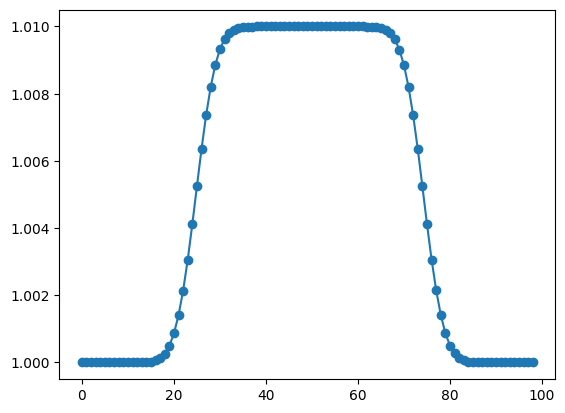

In [5]:
it +=1
plt.plot(state.uvecs[it,0,50,:], "-o")

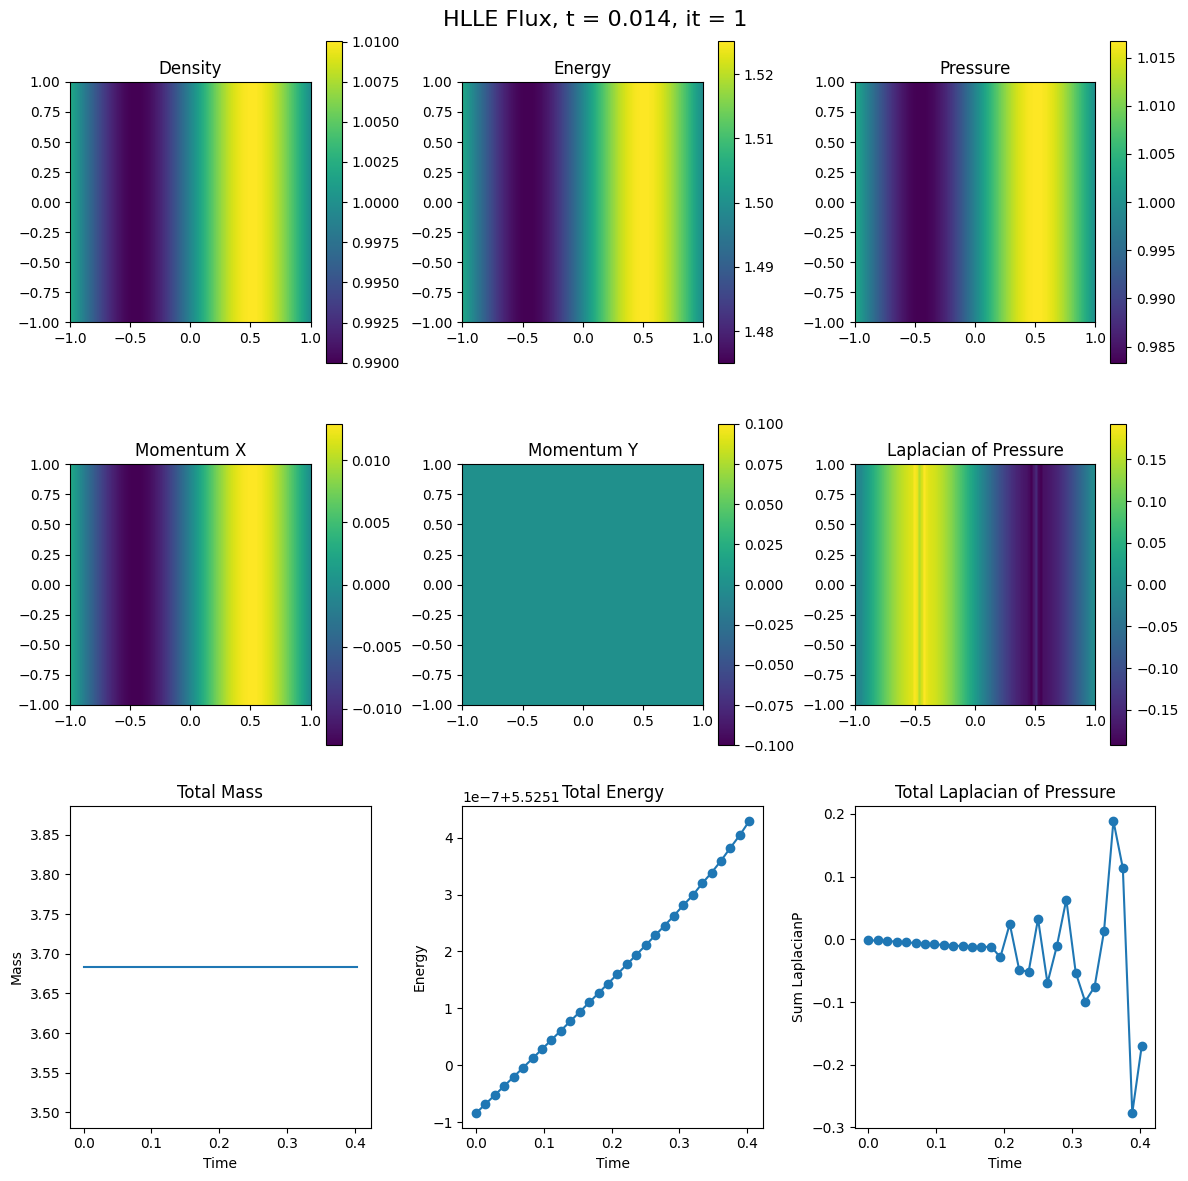

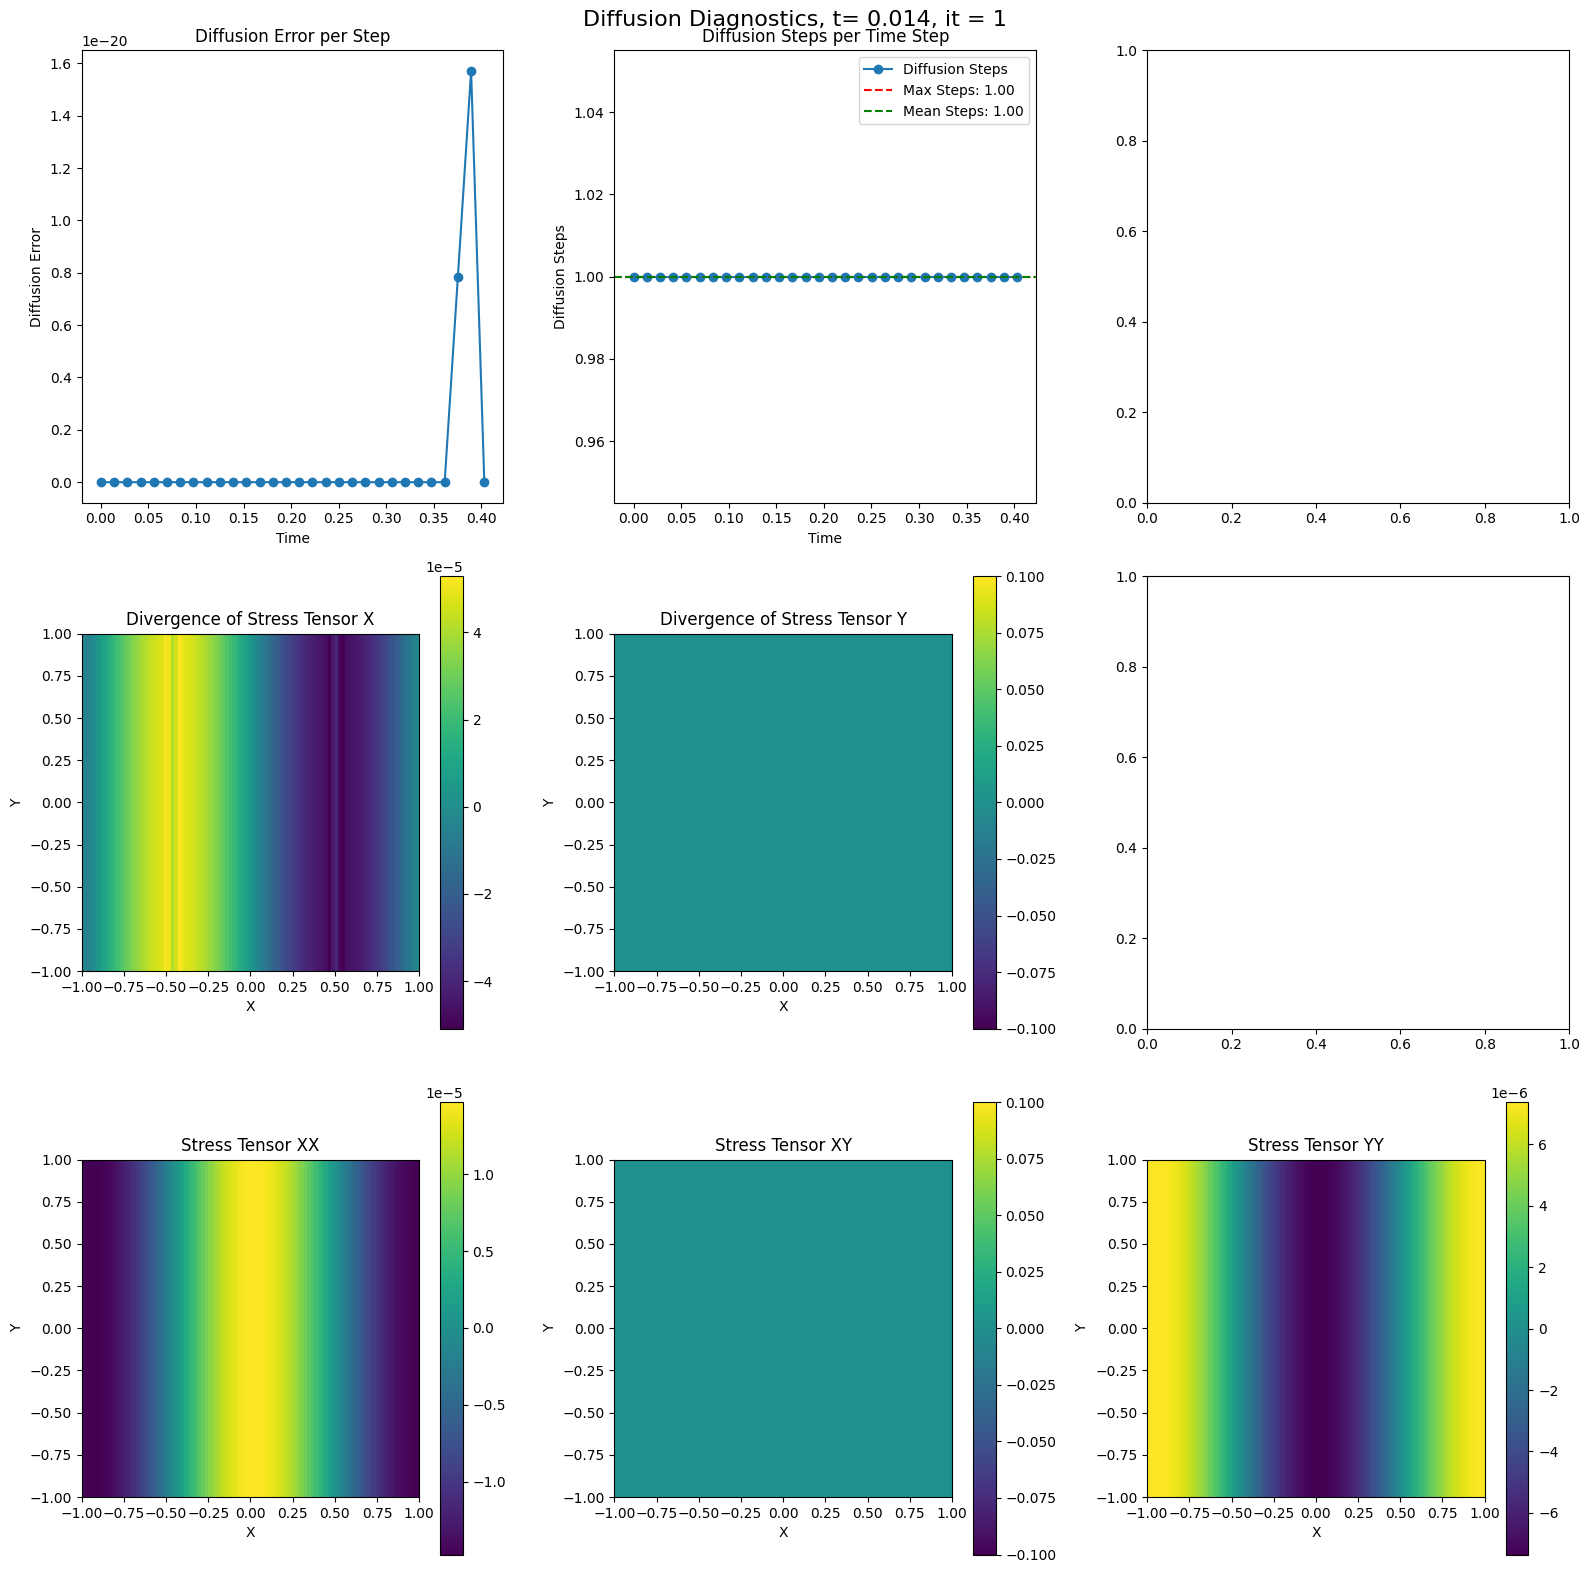

In [57]:
#it = 0
it +=1
state.plot_all(1)

MovieWriter ffmpeg unavailable; using Pillow instead.


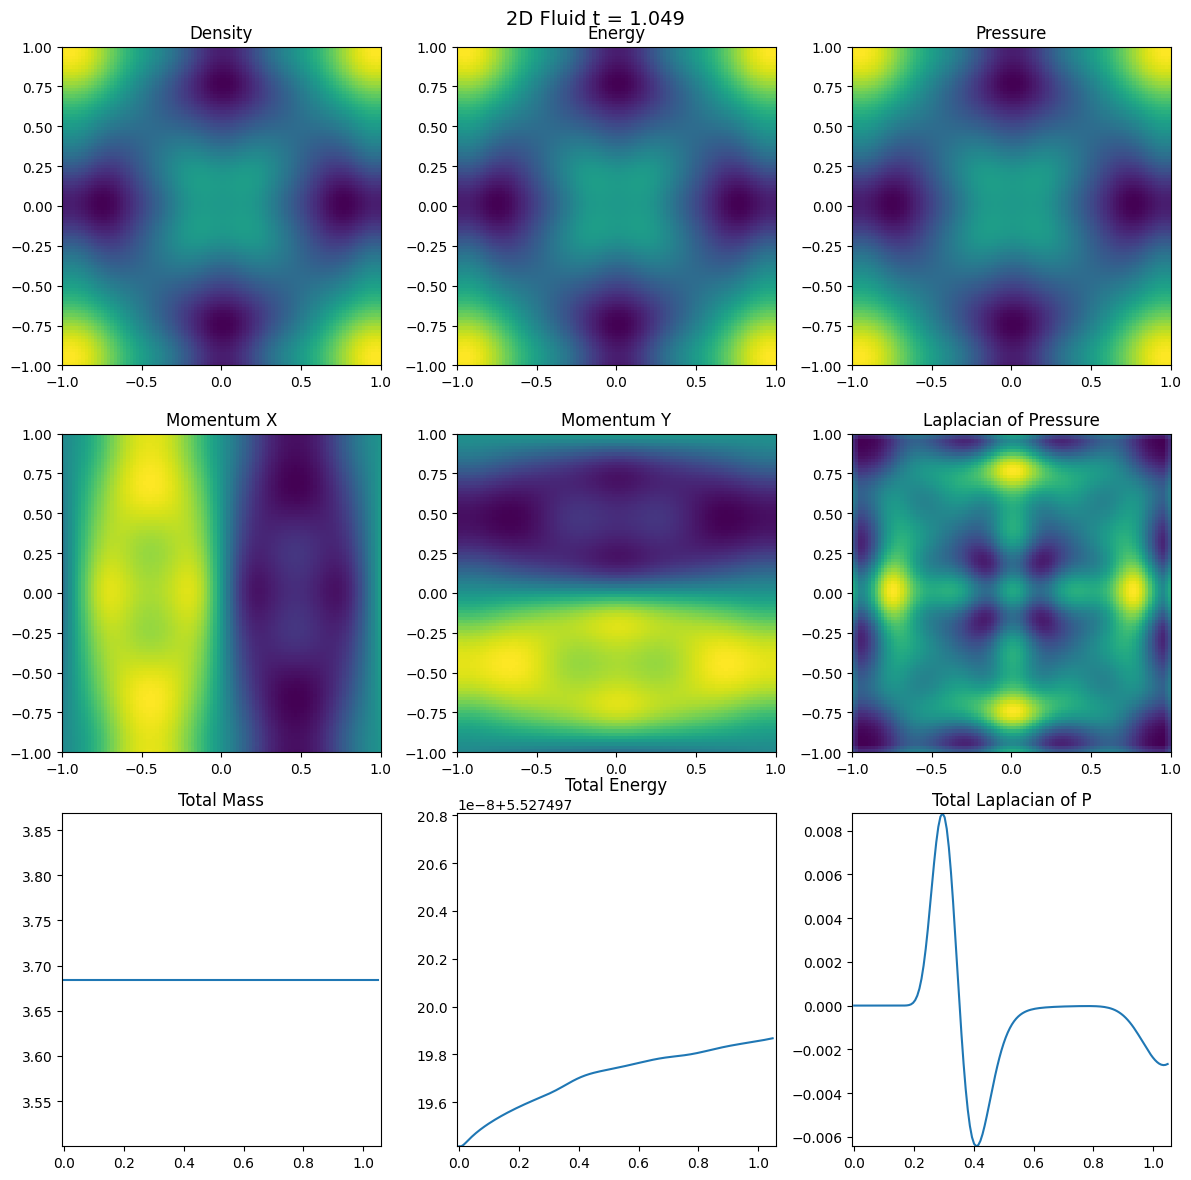

In [84]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
frames=200
framestep = 1;
framei = np.arange(frames)*framestep

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
title = fig.suptitle(f"2D Fluid t = {state.ts[0]:.3f}", fontsize=14)
# Initial plots (empty)

cutp = int(0.4*state.Nsteps)
im1 = axs[0,0].imshow(np.zeros_like(state.uvecs[0, 0]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.uvecs[cutp:,0].min(),vmax = state.uvecs[cutp:,0].max(), origin='lower')
im2 = axs[0,1].imshow(np.zeros_like(state.uvecs[0, 3]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.uvecs[cutp:,3].min(),vmax = state.uvecs[cutp:,3].max(), origin='lower')
im3 = axs[0,2].imshow(np.zeros_like(state.pressures[0]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.pressures[cutp:].min(),vmax = state.pressures[cutp:].max(), origin='lower')
im4 = axs[1,0].imshow(np.zeros_like(state.uvecs[0,1]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.uvecs[cutp:,1].min(),vmax = state.uvecs[cutp:,1].max(), origin='lower')
im5 = axs[1,1].imshow(np.zeros_like(state.uvecs[0,2]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.uvecs[cutp:,2].min(),vmax = state.uvecs[cutp:,2].max(), origin='lower')
im6 = axs[1,2].imshow(np.zeros_like(state.lapPs[0]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.lapPs[cutp:].min(),vmax = state.lapPs[cutp:].max(), origin='lower')
heatmaps = [im1, im2, im3, im4, im5, im6]

line1 = axs[2,0].plot([], [])[0]
line2 = axs[2,1].plot([], [])[0]
line3 = axs[2,2].plot([], [])[0]
axs[2,0].set_ylim(state.mtots[:frames+1].min()*0.9, state.mtots[:frames+1].max()*1.1)
axs[2,1].set_ylim(state.etots[:frames+1].mean() - 2*state.etots[:frames+1].std(), state.etots[:frames+1].mean() + 2*state.etots[:frames+1].std())
axs[2,2].set_ylim(state.laptots[:frames+1].min()*1.1, state.laptots[:frames+1].max()*1.1) 
for j in range(3):
   axs[2,j].set_xlim(-state.ts[1], state.ts[framei[-1]]*1.01)
lines = [line1, line2, line3]
plt.tight_layout()
def init():
   titles = [
      "Density",
      "Energy",
      "Pressure",
      "Momentum X",
      "Momentum Y",
      "Laplacian of Pressure",
      "Total Mass",
      "Total Energy",
      "Total Laplacian of P"
   ]

   
   for idx, ax in enumerate(axs.flat):
      ax.set_title(titles[idx])
   for line in lines:
      line.set_data([], [])
   return heatmaps + lines

def animate(frame):
   # Top 6 heatmaps (example: density, energy, momentum_x, momentum_y, pressure, laplacian_pressure)
   heatmaps[0].set_data(state.uvecs[frame, 0])
   heatmaps[1].set_data(state.uvecs[frame, 3])
   heatmaps[2].set_data(state.pressures[frame])
   heatmaps[3].set_data(state.uvecs[frame, 1])
   heatmaps[4].set_data(state.uvecs[frame, 2])
   heatmaps[5].set_data(state.lapPs[frame])
   heatmaps[0].set_clim(vmin=state.uvecs[frame,0].min(), vmax=state.uvecs[frame,0].max())
   heatmaps[1].set_clim(vmin=state.uvecs[frame,3].min(), vmax=state.uvecs[frame,3].max())
   heatmaps[2].set_clim(vmin=state.pressures[frame].min(), vmax=state.pressures[frame].max())
   heatmaps[3].set_clim(vmin=state.uvecs[frame,1].min(), vmax=state.uvecs[frame,1].max())
   heatmaps[4].set_clim(vmin=state.uvecs[frame,2].min(), vmax=state.uvecs[frame,2].max())
   heatmaps[5].set_clim(vmin=state.lapPs[frame].min(), vmax=state.lapPs[frame].max())  

   # Bottom 3 lines (cumulative up to current frame)
   lines[0].set_data(state.ts[:frame+1], state.mtots[:frame+1])
   lines[1].set_data(state.ts[:frame+1], state.etots[:frame+1])
   lines[2].set_data(state.ts[:frame+1], state.laptots[:frame+1])
   title.set_text(f"2D Fluid t = {state.ts[frame]:.3f}")

   return heatmaps + lines

anim = FuncAnimation(fig, animate, frames=framei, init_func=init, blit=True, interval=10*state.dts[0:framei[-1]].mean())
#HTML(anim.to_jshtml())
if not os.path.exists(f"{outdir2}"):
   os.makedirs(f"{outdir2}")
anim.save(f"{outdir2}/{state.icname}_anim.gif", writer="ffmpeg", fps=15, dpi=200)

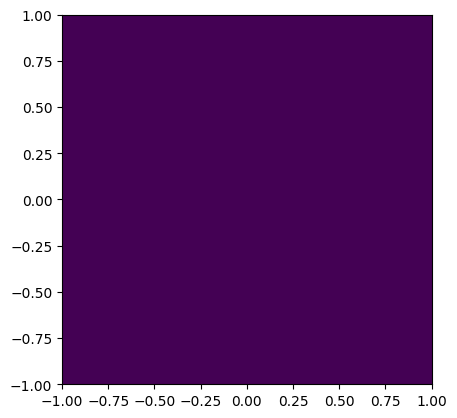

In [ ]:
plt.imshow(np.zeros_like(state.uvecs[0,0]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.uvecs[0].min(),vmax = state.uvecs[0].max(), origin='lower')

In [ ]:
state.uvecs[0,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(100, 100))